## 📦 Step 1: Imports and Dataset Loading

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
path = r"Weather-Data.csv"
df = pd.read_csv(path)

# Display first few rows
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


## 🧹 Step 2: Data Cleaning & Feature Engineering

In [2]:
# Parse the 'Formatted Date' column to datetime
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df['Year'] = df['Formatted Date'].dt.year
df['Month'] = df['Formatted Date'].dt.month
df['Day'] = df['Formatted Date'].dt.day
df['Hour'] = df['Formatted Date'].dt.hour

# Drop columns that are textual or not useful for modeling
df.drop(columns=['Formatted Date', 'Summary', 'Precip Type', 'Daily Summary', 'Loud Cover'], inplace=True)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Fill or drop missing values (if any)
df.dropna(inplace=True)

# View updated dataframe
df.head()


Missing values:
 Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Pressure (millibars)        0
Year                        0
Month                       0
Day                         0
Hour                        0
dtype: int64


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour
0,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,2006,3,31,22
1,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,2006,3,31,23
2,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,2006,4,1,0
3,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,2006,4,1,1
4,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,2006,4,1,2


## ⚙️ Step 3: Scaling + Sequence Generation

In [3]:
# Feature columns and target
feature_cols = df.columns.tolist()
target_col = 'Temperature (C)'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame for readability
scaled_df = pd.DataFrame(scaled_data, columns=feature_cols)

# Create sequences: 24 past hours -> 1 future hour temperature
sequence_length = 24
X, y = [], []

for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i][feature_cols.index(target_col)])

X, y = np.array(X), np.array(y)

print("Shape of X:", X.shape)  # (samples, time_steps, features)
print("Shape of y:", y.shape)


C:\Users\jpate\AppData\Local\Temp\ipykernel_14908\970936631.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(scaled_df.iloc[i][feature_cols.index(target_col)])


Shape of X: (96429, 24, 11)
Shape of y: (96429,)


## 🧪 Step 4: Train-Validation-Test Split
- We’ll split the data:

1. *`70% Training`*
2. *`15% Validation`*
3. *`15% Testing`*

In [4]:
# Train (70%) | Val (15%) | Test (15%) split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, shuffle=False)  # 0.1765 of 85% ≈ 15%

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (67497, 24, 11) (67497,)
Validation set: (14467, 24, 11) (14467,)
Test set: (14465, 24, 11) (14465,)


## 🧠 Step 5: CNN-BiLSTM Model Architecture
1. Use `Conv1D + MaxPooling1D` to capture `short-term patterns`
2. Feed that into `Bidirectional LSTM` for `temporal context`
3. Output a single temperature value


In [5]:
# Define the CNN-BiLSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

C:\Users\jpate\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape               ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                     │ (None, 22, 64)             │          2,176 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ max_pooling1d (MaxPooling1D)        │ (None, 11, 64)             │              0 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ bidirectional (Bidirectional)       │ (None, 128)                │         66,048 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout (Dropout)                   │ (None, 128)                │              0 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dense (Dense)                       │ (None, 32)                 │          4,128 │
├─────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dense_1 (Dense)                     │ (None, 1)                  │             33 │
└─────────────────────────────────────┴────────────────────────────┴────────────────┘

 Total params: 72,385 (282.75 KB)

 Trainable params: 72,385 (282.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.0081 - val_loss: 0.0020
Epoch 2/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 9.4358e-04 - val_loss: 0.0013
Epoch 4/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 8.2438e-04 - val_loss: 0.0026
Epoch 5/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 7.6063e-04 - val_loss: 0.0026
Epoch 6/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 7.0913e-04 - val_loss: 0.0029
Epoch 7/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 6.3000e-04 - val_loss: 0.0032


## ✅ Step 6: Evaluation & Predictions on Test Set
- Evaluate the model
- Invert scaling to get back actual temperature values
- Plot actual vs predicted values

453/453 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


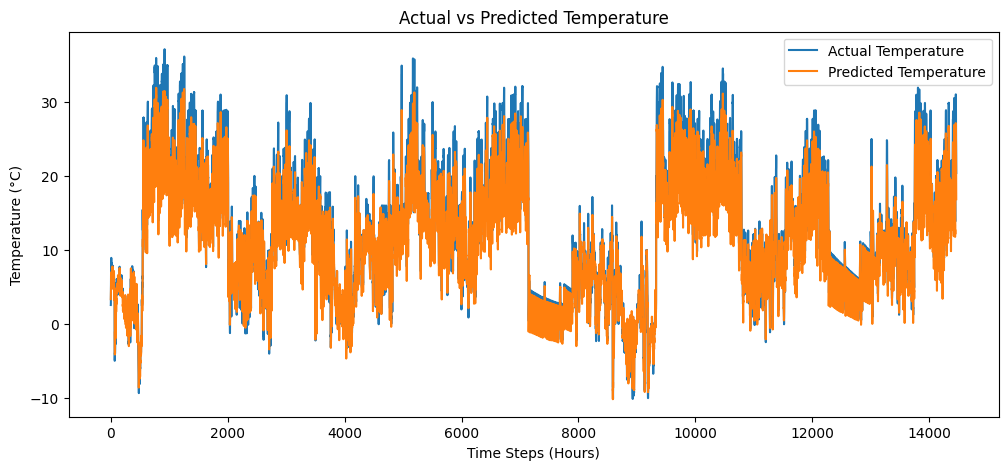

In [6]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Invert scaling for y_test and predictions
full_scaled = scaler.transform(df)
temp_index = df.columns.get_loc('Temperature (C)')

# Extract true values from scaled data
actual_temps_scaled = full_scaled[-len(y_test):, temp_index].reshape(-1, 1)

# Create a temp scaler for inverse transform
temp_scaler = MinMaxScaler()
temp_scaler.min_, temp_scaler.scale_ = scaler.min_[temp_index], scaler.scale_[temp_index]
temp_scaler.data_min_, temp_scaler.data_max_ = scaler.data_min_[temp_index], scaler.data_max_[temp_index]

y_pred_actual = temp_scaler.inverse_transform(y_pred_scaled)
y_test_actual = temp_scaler.inverse_transform(actual_temps_scaled)

# Plot predictions vs actual
plt.figure(figsize=(12, 5))
plt.plot(y_test_actual, label="Actual Temperature")
plt.plot(y_pred_actual, label="Predicted Temperature")
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test MSE: 4.9715
Test RMSE: 2.2297
Test MAE: 1.7081


In [8]:
def predict_temperature_user_input(model, df_original, scaler):
    try:
        # Step 1: Take user input
        year = int(input("Enter year (e.g., 2016): "))
        month = int(input("Enter month (1-12): "))
        day = int(input("Enter day (1-31): "))
        hour = int(input("Enter hour (0-23): "))
        
        # Step 2: Create a dataframe for input with all features
        input_df = df_original.copy()
        
        # Step 3: Filter to get the 24 hours before the requested time
        # First, reconstruct the Formatted Date column
        input_df['Formatted Date'] = pd.to_datetime(input_df[['Year', 'Month', 'Day', 'Hour']].assign(minute=0, second=0))
        input_time = pd.Timestamp(year=year, month=month, day=day, hour=hour)
        start_time = input_time - pd.Timedelta(hours=24)
        
        # Filter data for the previous 24 hours
        mask = (input_df['Formatted Date'] >= start_time) & (input_df['Formatted Date'] < input_time)
        input_data = input_df.loc[mask]
        
        if len(input_data) < 24:
            print("❗ Not enough historical data to make a prediction (need full 24 hours).")
            return None
        
        # Prepare input data (match the format used during training)
        input_data.drop(columns=['Formatted Date'], inplace=True)
        
        # Scale the input data
        scaled_input = scaler.transform(input_data.tail(24))
        X_input = np.expand_dims(scaled_input, axis=0)  # Shape: (1, 24, features)
        
        # Make prediction
        y_pred_scaled = model.predict(X_input)
        
        # Extract temperature column index for inverse scaling
        temp_index = df_original.columns.get_loc('Temperature (C)')
        
        # Create temperature scaler for inverse transform
        temp_scaler = MinMaxScaler()
        temp_scaler.min_, temp_scaler.scale_ = scaler.min_[temp_index], scaler.scale_[temp_index]
        temp_scaler.data_min_, temp_scaler.data_max_ = scaler.data_min_[temp_index], scaler.data_max_[temp_index]
        
        # Convert prediction back to original scale
        predicted_temp = temp_scaler.inverse_transform(y_pred_scaled)[0][0]
        
        print(f"\n🌡️ Predicted Temperature for {input_time.strftime('%Y-%m-%d %H:%M')} is: {predicted_temp:.2f}°C")
        return predicted_temp
        
    except Exception as e:
        print("❌ Invalid input or prediction error:", str(e))
        return None

In [9]:
# Recreate the Formatted Date column for the prediction function
df['Formatted Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']].assign(minute=0, second=0))

# Call the function with correct parameters
predict_temperature_user_input(model=model, 
                              df_original=df,
                              scaler=scaler)

Enter year (e.g., 2016):  2008
Enter month (1-12):  1
Enter day (1-31):  2
Enter hour (0-23):  10


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

🌡️ Predicted Temperature for 2008-01-02 10:00 is: -4.01°C


C:\Users\jpate\AppData\Local\Temp\ipykernel_14908\98742823.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.drop(columns=['Formatted Date'], inplace=True)


np.float32(-4.009131)

In [10]:
# Save
model.save("weather_temp_predictor.keras")

# Load later
from tensorflow.keras.models import load_model
model = load_model("weather_temp_predictor.keras")
